# An exploratory data analysis (EDA) workflow with the Titanic dataset

In this post, I use the Titanic dataset from Kaggle (a relatively clean and simple dataset) to walk through an exploratory data analysis (EDA) work flow. I primarily use `pandas` dataframes to manipulate the data, and `seaborn` and `matplotlib` for plotting. Prior to plotting or even looking at the data, I like to make sure that I am clear on the question, and form some initial hypotheses as to what may explain or predict the outcome variable. This will guide both the feature engineering and plotting that I will do in my EDA.

## General steps for EDA:

1. Question
    - What are we trying to answer?
    - What variables should be considered?
    - __Explain vs. Predict__ - this guides what __models__ and __features__ we should think about using
        - __Predict__: If we are preparing a presentation to explain a key performance metric to the leadership team, we probably want to choose a more interpretable model like logistic regression. We may also want to limit features to only those that are actionable for the business, etc.
        - __Explain__: If we are trying to win a Kaggle competition, we are more interested in _accurate_ predictions and may choose a less interpretable model (random forest, gradient boosting, etc.) and include any feature if it helps our accuracy even a slight bit
2. Data Cleaning
    - Identify missing data - is it missing due to randomness or is it meaningful?
    - Data type conversion - are features that are integer type actually numeric in nature (ex: PassengerId)?
    - Mapping features for easier modeling - change Yes/No to 1/0, categorical features => dummy variables, etc.
3. Plotting
    - Identify potential correlations in features
    - Select features to include in model
    - Form hypotheses to inform feature engineering that may be needed

### 1. Question

The goal in the Kaggle Titanic challenge is to predict survival with the highest accuracy. This is a prediction problem.

### 2. Data Cleaning

First, we import all of the libraries we will need.

In [8]:
from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier
from statsmodels.discrete.discrete_model import Logit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.tools.plotting import scatter_matrix
%matplotlib inline

In [3]:
# Set font for plotting
sns.set(font_scale=1.5)

Load the data:

In [4]:
train = pd.read_csv('train.csv')

Variable Descriptions:

|Name            | Description |
|--|-------------------------------|
|survival        | Survival (0 = No; 1 = Yes) |
|pclass          | Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)|
|name            | Name |
|sex             | Sex |
|age             | Age |
|sibsp           | Number of Siblings/Spouses Aboard |
|parch           | Number of Parents/Children Aboard |
|ticket          | Ticket Number |
|fare            | Passenger Fare |
|cabin           | Cabin |
|embarked        | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)|

I like to get a summary of a new dataset with the following:
- `.shape` lets us know how many rows and columns we are dealing with
- `.head()` gives me an idea of what the data looks like
- `.info()` tells me about data types and missing values that may be of concern

In [5]:
train.shape

(891, 12)

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Cabin data is pretty sparse. Age is missing some data. Embarked is missing only a couple data points.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


This next part involves some more code. I wrote my data cleaning and feature engineering code in a `DataCleaning` class because it gets repetitive and potentially error-prone writing individual functions that return a new data frame for each transformation. It's better to have your class store your data and follow it all the way through.

An alternative way to do this is to use `DataFrameMapper` from [`sklearn-pandas`](https://github.com/paulgb/sklearn-pandas), which is like a pipeline for dataframes, and you can even use it as a step within your `sklearn.pipeline` (the link shows how to do this). I will probably do a separate blog post on this later on as it's generally good practice to use pipeline to scale your training and test data for modeling.

In [9]:
class DataCleaning(object):

    def __init__(self, X, X_test=None):
        '''
        Input: features from training set (df), optional features from test set (df)
        '''
        self.X = X
        self.n_train = X.shape[0]
        self.X_test = X_test

    def combine_data(self):
        '''
        Combine train and test data for processing, if there is test data input
        '''
        self.X = self.X.append(self.X_test)

    def cabin_prefix(self):
        '''
        Trim cabin number and include only letter prefix
        '''
        self.X['Cabin'] = self.X['Cabin'].fillna('Unknown').str[0]

    def fill_age_with_median(self):
        self.X['Age'] = self.X['Age'].fillna(self.X['Age'].median())
        self.X['AgeMissing'] = self.X['Age'].isnull().astype(int)

    def fill_embarked_with_mode(self):
        self.X['Embarked'] = self.X['Embarked'].fillna(self.X['Embarked'].mode()[0])

    def fill_fare_with_mean(self):
        self.X['Fare'] = self.X['Fare'].fillna(self.X['Fare'].mean())

    def man_woman_child(self):
        '''
        Create new grouping of Child, Adult Man, or Adult woman based on Age and Sex
        '''
        def apply_func(age_sex):
            age, sex = age_sex
            if age < 16:
                return 'Child'
            else:
                return 'Woman' if sex == 'female' else 'Man'
        self.X['PersonType'] = self.X[['Age', 'Sex']].apply(apply_func, axis=1)

    def title_from_name(self):
        '''
        Credit to Ahmed BESBES (ahmedbesbes.com) for this clever way of using the the names to extract titles. This maps the various titles into groups: Officer, Royalty, Mrs, Miss, Mr, Master
        '''
        title_dict = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

        self.X['Title'] = self.X['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip()).map(title_dict)

    def remove_name_and_ticket(self):
        '''
        Delete Name and Ticket columns as they won't be used in our modeling
        '''
        del self.X['Name']
        del self.X['Ticket']

    def family_size_vars(self):
        '''
        Get total family size by adding siblings/spouse + parents/children
        Identify those who were traveling alone
        '''
        self.X['TotalFamily'] = self.X['SibSp'] + self.X['Parch']
        self.X['SelfOnly'] = self.X['TotalFamily'].map(lambda x: 1 if x == 0 else 0)

    def categorical_dummies(self):
        '''
        Create dummy variables for categorical data so that output data is all numeric and ready for scaling / modeling.
        '''
        cols = ['Pclass', 'Sex', 'Cabin', 'Embarked', 'PersonType', 'Title']
        for col in cols:
            dummies = pd.get_dummies(
                self.X[col], prefix=col) # drop_first=True
            self.X = pd.concat([self.X, dummies], axis=1)
            del self.X[col]
        return self.X

    def clean_data(self, dummies=True):
        '''
        Runs all data cleaning steps
        '''
        if self.X_test is not None:
            self.combine_data()
        self.cabin_prefix()
        self.fill_age_with_median()
        self.fill_embarked_with_mode()
        self.fill_fare_with_mean()
        self.man_woman_child()
        self.title_from_name()
        self.remove_name_and_ticket()
        self.family_size_vars()
        if dummies:
            self.categorical_dummies()

    def output_data(self):
        '''
        Split and output training and test data
        '''
        if self.X_test is not None:
            return self.X[:self.n_train], self.X[self.n_train:]
        else:
            return self.X

That's the code. Here's how we run it:

In [10]:
# Initiate a DataCleaning instance
data = DataCleaning(train)

# Run method that runs all transformations
# Note: dummies=True creates dummy variables (1/0) for categorical variable levels for modeling, which requires a numeric matrix.
# For plotting purposes, we won't create these dummy variables yet.
data.clean_data(dummies=False)

# Output transformed dataframe
train = data.output_data()

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
AgeMissing     891 non-null int64
PersonType     891 non-null object
Title          891 non-null object
TotalFamily    891 non-null int64
SelfOnly       891 non-null int64
dtypes: float64(2), int64(8), object(5)
memory usage: 104.5+ KB


Now the data types look good, and no missing values.

### 3. Plotting

<img src='img/wc.jpg'>

Let's look at __women and children__ first. Indeed, women and children had a higher chance of survival than men on the Titanic. Apparently this is [not typically the case in maritime disasters](http://www.livescience.com/21951-women-children-first-shipwreck-myth.html).

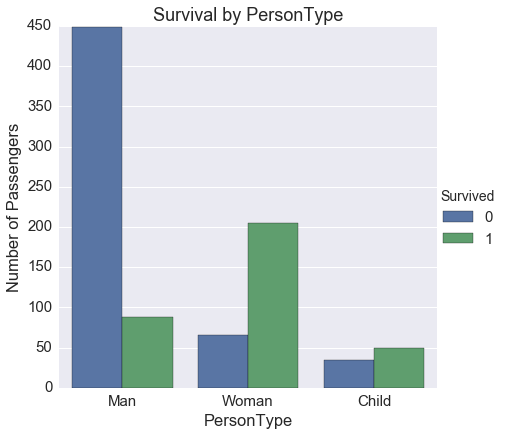

In [44]:
ax = sns.factorplot(x="PersonType", hue="Survived", data=train, kind="count", size=6)
ax.set(ylabel='Number of Passengers')
plt.title('Survival by PersonType');

Next we compare the __age__ of those who survived vs. those who didn't. We see more younger children in those who survived, and more middle-aged adults in those who didn't survive.

For plotting numerical data, I prefer KDE plots over histograms for an initial look because the latter may miss some detail in the distribution depending on bin size.

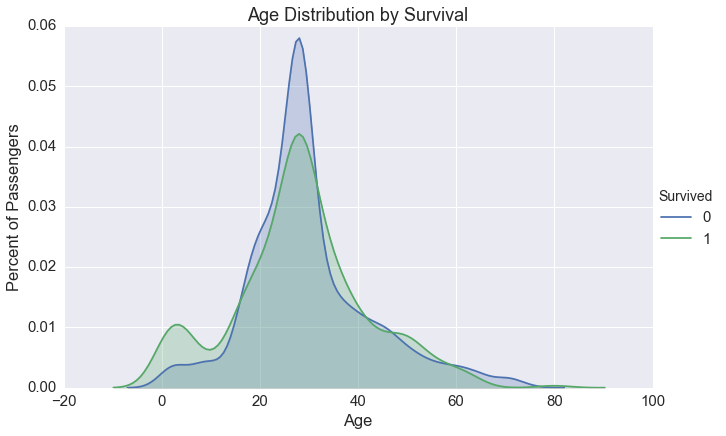

In [35]:
fg = sns.FacetGrid(data=train, hue="Survived", aspect=1.5, size=6)
fg.map(sns.kdeplot, "Age", shade=True)
fg.set(ylabel='Percent of Passengers')
fg.add_legend()
plt.title('Age Distribution by Survival');

__So did Rose survive because she was a woman, or because she was rich?__ Let's have a look at passenger class. Here we see that 1st class passengers who paid a higher fare had greater chance of survival than the other classes.

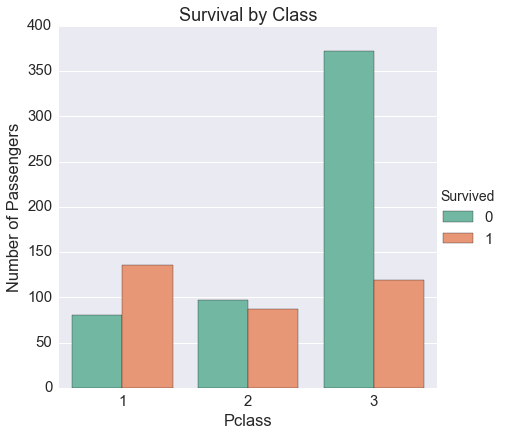

In [37]:
ax = sns.factorplot(x="Pclass", hue="Survived", data=train, kind="count", size=6, palette="Set2")
ax.set(ylabel='Number of Passengers')
plt.title('Survival by Class');

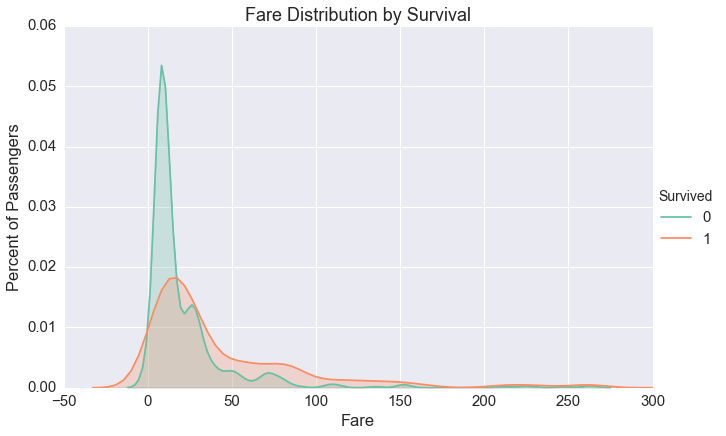

In [38]:
fg = sns.FacetGrid(data=train, hue="Survived", aspect=1.5, size=6, palette="Set2")
fg.map(sns.kdeplot, "Fare", shade=True)
fg.set(ylabel='Percent of Passengers')
fg.add_legend()
plt.title('Fare Distribution by Survival')
plt.xlim([-50, 300]);

Here are a few ways to plot interactions (Person Type vs. Passenger Class in this case). It seems like men in 2nd or 3rd class fared the worst.

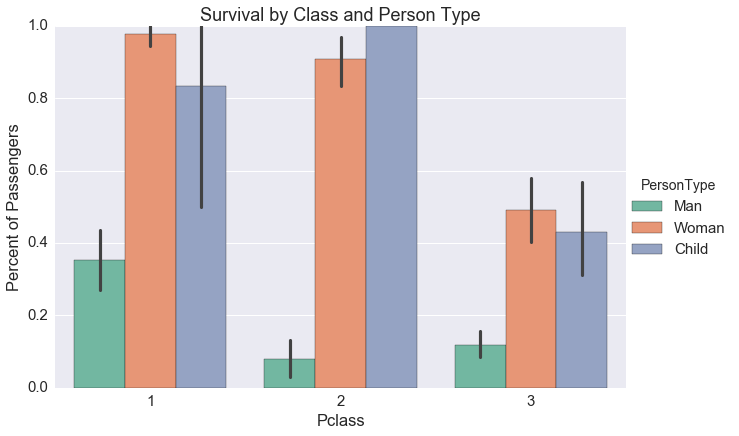

In [39]:
ax = sns.factorplot(x="Pclass", y="Survived", hue="PersonType", data=train, kind="bar", aspect=1.5, size=6, palette="Set2")
ax.set(ylabel='Percent of Passengers')
plt.title('Survival by Class and Person Type');

Another way to look at this interaction is with violin plots (essentially histograms rotated by 90 degrees). Most people don't seem to be a fan of these, but I think they're cool to look at. Here you'll notice a bump in children from 2nd and 3rd class who survived.

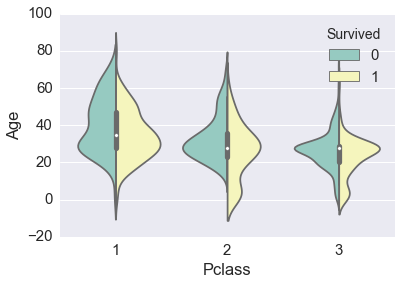

In [32]:
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=train, split=True, size=6, palette="Set3");

For interactions in numeric features, we can look at a __correlation matrix__. 0 means no correlation, 1 is positive correlation, and -1 is negative correlation. Pclass/Fare and TotalFamily/SelfOnly are both negatively correlated, as we would expect.

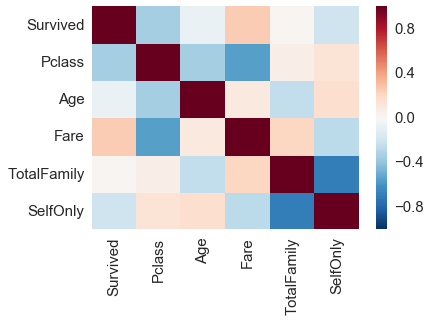

In [25]:
corr = train[['Survived', 'Pclass', 'Age', 'Fare', 'TotalFamily', 'SelfOnly']].corr()
sns.heatmap(corr)

We saw that 1st class passengers who paid a higher fare have a better chance of survival. How does this relate to other features? Are the rich more likley to be in a certain Cabin area? Or Embark location?

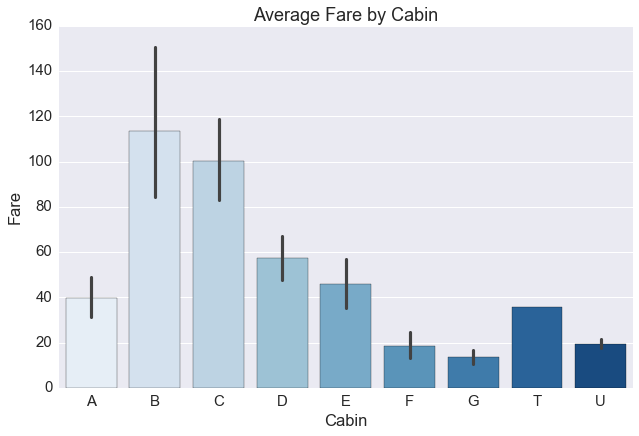

In [18]:
sns.factorplot(x='Cabin', y='Fare', data=train, kind='bar', aspect=1.5, size=6, order=sorted(train['Cabin'].unique()), palette="Blues")
plt.title('Average Fare by Cabin');

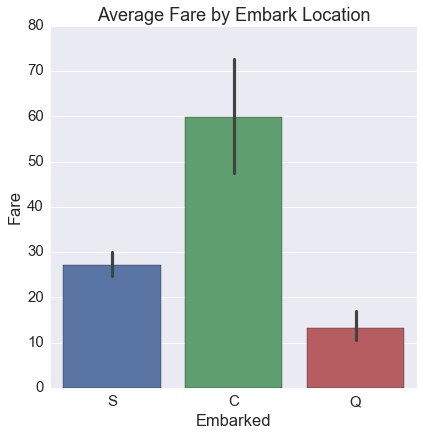

In [19]:
sns.factorplot(x='Embarked', y='Fare', data=train, kind='bar', size=6)
plt.title('Average Fare by Embark Location');

From our Title feature that we extracted from passenger names - are royalty or masters more likely to survive? Here, it looks like Title may just be a proxy for gender.

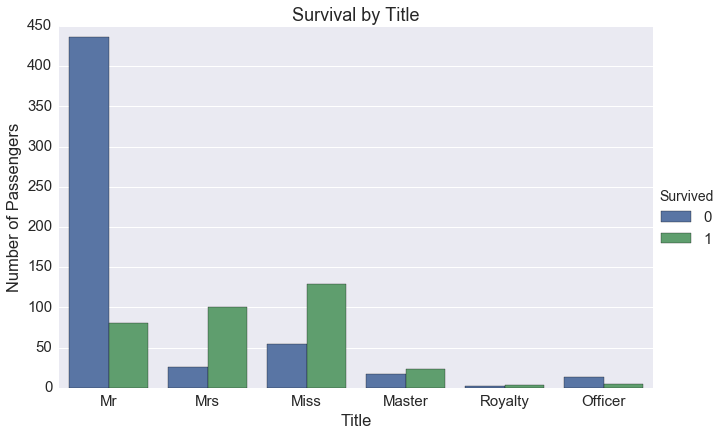

In [40]:
ax = sns.factorplot(x='Title', hue='Survived', data=train, kind='count', aspect=1.5, size=6)
ax.set(ylabel='Number of Passengers')
plt.title('Survival by Title');

Did bigger families have a higher chance of survival than single travelers? Yes for family sizes up to around 4, but not so much for those beyond that. Judging from the error bars, it seems like there weren't very many of these.

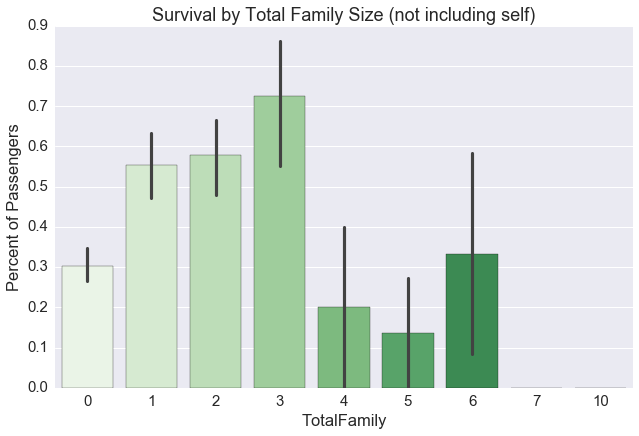

In [41]:
ax = sns.factorplot(x='TotalFamily', y='Survived', data=train, kind='bar', aspect=1.5, size=6, palette="Greens")
ax.set(ylabel='Percent of Passengers')
plt.title('Survival by Total Family Size (not including self)');

That wraps up EDA. In my next post, I will take this data through a machine learning workflow. The focus of the post will be on _process_ - the journey and not the destination 8) - so I would seek out additional resources if your goal is to make a dent on the Kaggle leaderboard. Stay tuned!